# Projet 6 : Implémentez un modèle de scoring

L'objectif est de développer un modèle de scoring de la probabilité de défaut de paiement d'un client pour étayer la décision d'accorder ou non un prêt à un client potentiel

Les données sont plusieurs fichiers '.csv' qui renseignent des informations concernant les clients d'une banque. 

Le fichier 'application_train' donne de multiples informations sur des clients qui ont effectué un emprunt ainsi que la mention remboursé ou défaut de payement sur cet emprunt. 

Le fichier application_test renseigne exactement les mêmes informations que le fichier 'application_train', mais il s'agit de déterminer la probabilité de défaut de paiement pour ces nouveaux emprunts.

Quant aux autres fichiers il s'agit d'informations relatives à des emprunts antérieurs qui ont été accordés soit par d'autres institutions soit par la même banque.

L'organigramme ci-dessous présente l'ensemble des fichiers à notre disposition, leur contenu ansi que les liens qui les relient.

<img src="home_credit.png">

Les données sont disponibles à l'adresse suivante : https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/Parcours_data_scientist/Projet+-+Impl%C3%A9menter+un+mod%C3%A8le+de+scoring/Projet+Mise+en+prod+-+home-credit-default-risk.zip

Cette partie est décomposé en 3 sous parties.

La première partie est une brève description des données 'application_train/test'.

- Pour chaque variable numérique des jeux de données, il y a des informations concernant le pourcentage de données manquantes, la moyenne, la médianne, l'écart-type etc...
- Pour chaque variable catégorielle, il y a des informations concernant  les données manquantes et pour chaque valeur prise par la variable il y a le nombre d'occurences
    
La deuxième partie s'intéresse au nettoyage des données.
    
- Les individus dont les valeurs des variables catégorielles  sont non communes aux jeux test et d'entrainement sont supprimés ainsi que les individus dont les valeurs trop peu fréquentes
- Les valeurs abérrantes de certaines variables numériques sont remplacés par 'NaN' pour une imputation ultérieure

## Table des matières

* [1. Description des données](#partie1)
* [2. Nettoyage des données](#partie2)
    * [2.1 Variables catégorielles](#Section_2_1)
    * [2.2 Variables numériques](#Section_2_2)
    * [2.3 Feature engineering](#Section_2_3)
        * [2.3.1 Feature Engineering automatisé](#sSection_2_3_1)
        * [2.3.2 Feature Engineering manuel](#sSection_2_3_2)
    * [2.4 Données manquantes](#Section_2_4)   
* [3. Encondage des variables catégorielles](#partie3)
    * [3.1 Encodage des 'variables temporelles'](#Section_3_1)
    * [3.2 Encodage des autres variables catégorielles](#Section_3_2)

### Accès Drive


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Chargement des librairies

In [4]:
pip install featuretools

In [5]:
# Load packages
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Transformations de variables
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# Feature engineering
import featuretools as ft
from featuretools import selection

# Data Augmentation
from imblearn.over_sampling import SMOTE

# Metrics de ML
from sklearn.metrics import auc, roc_curve, roc_auc_score, make_scorer
from sklearn.metrics import precision_recall_curve

# Packages de cross_validation
from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedKFold
from sklearn.calibration import calibration_curve, CalibratedClassifierCV

# Packages hyperopt pour la séléction d'hyperparamètres
from hyperopt import hp, tpe
from hyperopt.fmin import fmin

# Modèles de ML
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.dummy import DummyClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import ElasticNet
from xgboost import plot_importance

# Librairies graphiques
import plotly.offline as py
import plotly.graph_objs as go
import plotly.offline as offline
import plotly.graph_objects as go
from plotly.subplots import make_subplots


from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline

# Plot settings
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
sns.set()

/usr/local/lib/python3.7/dist-packages/alteryx_open_src_update_checker/functions.py:38: UserWarning: woodwork is out-of-date: installed == 0.11.2, latest == 0.12.0
  warnings.warn(msg)
ERROR:numba.cuda.cudadrv.driver:Call to cuInit results in CUDA_ERROR_NO_DEVICE


## 1. Description des données <a class="anchor" id="partie1"></a>

#### Lecture des données

In [122]:
# Garder un % donné des dataframe
def sample_first_prows(data, perc=0.1):
    #import pandas as pd
    return data.head(int(len(data)*(perc)))

In [123]:
# Lecture des données
train_set = pd.read_csv('/content/drive/MyDrive/P7_credit/Data/application_train.csv').sort_values("SK_ID_CURR")
test_set = pd.read_csv('/content/drive/MyDrive/P7_credit/Data/application_test.csv').sort_values("SK_ID_CURR")
bureau = pd.read_csv("/content/drive/MyDrive/P7_credit/Data/bureau.csv").sort_values(['SK_ID_CURR', 'SK_ID_BUREAU'])
bureau_balance = pd.read_csv("/content/drive/MyDrive/P7_credit/Data/bureau_balance.csv").sort_values("SK_ID_BUREAU")
cash_balance = pd.read_csv("/content/drive/MyDrive/P7_credit/Data/POS_CASH_balance.csv").sort_values(['SK_ID_CURR', 'SK_ID_PREV'])
card_balance = pd.read_csv('/content/drive/MyDrive/P7_credit/Data/credit_card_balance.csv').sort_values(['SK_ID_CURR', 'SK_ID_PREV'])
prev_app = pd.read_csv('/content/drive/MyDrive/P7_credit/Data/previous_application.csv').sort_values(['SK_ID_CURR', 'SK_ID_PREV'])
payments = pd.read_csv('/content/drive/MyDrive/P7_credit/Data/installments_payments.csv').sort_values(['SK_ID_CURR', 'SK_ID_PREV'])

In [124]:
# Lecture des données
train_set = sample_first_prows(train_set)
test_set = sample_first_prows(test_set)
bureau = sample_first_prows(bureau)
bureau_balance = sample_first_prows(bureau_balance)
cash_balance = sample_first_prows(cash_balance)
card_balance = sample_first_prows(card_balance)
prev_app = sample_first_prows(prev_app)
payments = sample_first_prows(payments)

#### Apperçu des données

In [125]:
# Affiche les 5 premières lignes des données d'entrainement
train_set.head(5)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,...,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,...,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,...,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039,-9833.0,-2437,NaN,1,1,0,1,0,0,Laborers,2.0,2,2,WEDNESDAY,17,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,2.0,0.0,-617.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.028663,-19932,-3038,-4311.0,-3458,NaN,1,1,0,1,0,0,Core staff,1.0,2,2,THURSDAY,11,0,0,0,0,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-1106.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


#### Structure des données

In [126]:
def describe_columns_df(df):
    """
    Affiche la description détaillée du contenu de chaque colonne de df
    df(pd.Dataframe): jeu de données
    """
    for col in df:
        print(col)
        null = df[col].isnull().sum()
        # affiche le nombre de valeurs manquantes
        print('Number of empty : ', null)
        # affiche le pourcentage de valeurs manquantes
        print('Percent of empty : ', 100*null/df.shape[0])
        print(df[col].describe())
        if df[col].dtype == object:
            print('Categories and Count:')
            print(df[col].value_counts().to_string(header=None))
        print('\n')

In [127]:
# Affiche la description détaillée du contenu
# de chaque colonne du jeu d'entrainement
describe_columns_df(train_set)

SK_ID_CURR
Number of empty :  0
Percent of empty :  0.0
count     30751.000000
mean     117901.275373
std       10314.283222
min      100002.000000
25%      108963.500000
50%      117945.000000
75%      126837.500000
max      135691.000000
Name: SK_ID_CURR, dtype: float64


TARGET
Number of empty :  0
Percent of empty :  0.0
count    30751.000000
mean         0.080127
std          0.271495
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: TARGET, dtype: float64


NAME_CONTRACT_TYPE
Number of empty :  0
Percent of empty :  0.0
count          30751
unique             2
top       Cash loans
freq           27784
Name: NAME_CONTRACT_TYPE, dtype: object
Categories and Count:
Cash loans         27784
Revolving loans     2967


CODE_GENDER
Number of empty :  0
Percent of empty :  0.0
count     30751
unique        2
top           F
freq      20219
Name: CODE_GENDER, dtype: object
Categories and Count:
F    20219
M    10532


FLAG

In [128]:
# Affiche la description détaillée du contenu de chaque colonne du jeu test
describe_columns_df(test_set)

SK_ID_CURR
Number of empty :  0
Percent of empty :  0.0
count      4874.000000
mean     117258.649159
std       10080.226689
min      100001.000000
25%      108586.000000
50%      117039.500000
75%      125952.500000
max      135241.000000
Name: SK_ID_CURR, dtype: float64


NAME_CONTRACT_TYPE
Number of empty :  0
Percent of empty :  0.0
count           4874
unique             2
top       Cash loans
freq            4837
Name: NAME_CONTRACT_TYPE, dtype: object
Categories and Count:
Cash loans         4837
Revolving loans      37


CODE_GENDER
Number of empty :  0
Percent of empty :  0.0
count     4874
unique       2
top          F
freq      3248
Name: CODE_GENDER, dtype: object
Categories and Count:
F    3248
M    1626


FLAG_OWN_CAR
Number of empty :  0
Percent of empty :  0.0
count     4874
unique       2
top          N
freq      3240
Name: FLAG_OWN_CAR, dtype: object
Categories and Count:
N    3240
Y    1634


FLAG_OWN_REALTY
Number of empty :  0
Percent of empty :  0.0
count     4874

#### Variable 'TARGET'

La nom de la colonne dont on cherche à prédire la valeur est "TARGET".

La variable prend soit la valeur 0 quand le prêt a été remboursé sans soucis, soit la valeur 1 quand il y a eu un défaut de payement.

In [129]:
def solvability_clients(df):
    """
    Pieplot de la solvabilité clients
    df(pd.DataFrame): jeu de données
    """
    # % de valeurs 'TARGET' différentes
    target_values = df['TARGET'].value_counts()/len(df)*100
    # Pieplot du % de chaque valeurs différentes de 'TARGET'
    plt.pie(target_values,
            colors=['#2ecc71', '#e74c3c'],
            autopct='%1.1f%%',
            labels=["Solvable", "Non Solvable"],
            startangle=90)
    plt.show()

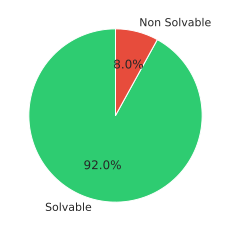

In [130]:
# Pieplot solvabilité clients du jeu d'entrainement
solvability_clients(train_set)

92 % des prêts ont été remboursés et donc 8 % des individus ont été non solvables.

## 2. Nettoyage des données <a class="anchor" id="partie2"></a>

Dans cette partie, les jeu de données d'entrainement et de test sont concaténés pour traiter les features de manière conjointe

In [131]:
def merge_train_test(df_train, df_test):
    """
    Merge les jeu d'entrainement et de test en rajoutant
    une colonne 'Test' qui prend les valeurs True ou False
    df_train(pd.DataFrame): jeu d'entrainement
    df_test(pd.DataFrame): jeu test
    """

    df_train['Test'] = False
    df_test['Test'] = True
    df_test['TARGET'] = np.nan
    app = train_set.append(test_set,
                           ignore_index=True,
                           sort=False)
    return app

In [132]:
# Merge jeu d'entrainement et jeu de test
app = merge_train_test(train_set, test_set)

### 2.1 Variables catégorielles <a class="anchor" id="Section_2_1"></a>

#### Liste des variables catégorielles et valeurs prises

In [133]:
def display_cat_columns(app):
    """
    Pour chaque colonne catégorielle, indique le nombre et le nom
    des différentes valeurs prises
    """

    for col in app:
        if app[col].dtype == object:
            print(col)
            print('Number Unique in Train:', app[~app['Test']][col].nunique())
            print('Number Unique in Test: ', app[app['Test']][col].nunique())
            print('Unique in Train: ',
                  sorted([str(e) for e in
                          app[~app['Test']][col].unique().tolist()]))
            print('Unique in Test: ',
                  sorted([str(e) for e in
                          app[app['Test']][col].unique().tolist()]))
            print('\n')

In [134]:
# Descriptif des variables catégorielles
display_cat_columns(app)

NAME_CONTRACT_TYPE
Number Unique in Train: 2
Number Unique in Test:  2
Unique in Train:  ['Cash loans', 'Revolving loans']
Unique in Test:  ['Cash loans', 'Revolving loans']


CODE_GENDER
Number Unique in Train: 2
Number Unique in Test:  2
Unique in Train:  ['F', 'M']
Unique in Test:  ['F', 'M']


FLAG_OWN_CAR
Number Unique in Train: 2
Number Unique in Test:  2
Unique in Train:  ['N', 'Y']
Unique in Test:  ['N', 'Y']


FLAG_OWN_REALTY
Number Unique in Train: 2
Number Unique in Test:  2
Unique in Train:  ['N', 'Y']
Unique in Test:  ['N', 'Y']


NAME_TYPE_SUITE
Number Unique in Train: 7
Number Unique in Test:  7
Unique in Train:  ['Children', 'Family', 'Group of people', 'Other_A', 'Other_B', 'Spouse, partner', 'Unaccompanied', 'nan']
Unique in Test:  ['Children', 'Family', 'Group of people', 'Other_A', 'Other_B', 'Spouse, partner', 'Unaccompanied', 'nan']


NAME_INCOME_TYPE
Number Unique in Train: 7
Number Unique in Test:  5
Unique in Train:  ['Businessman', 'Commercial associate', 'Pen

##### Variable 'CODE_GENDER'

Le jeu d'entrainement contient seulement 4 valeurs nommés 'XNA' pour la colonne renseignant le genre. Ces emprunts sont supprimés

In [135]:
# Supprime les individus dont le genre est 'XNA'
app = app[app['CODE_GENDER'] != 'XNA']

##### Variable 'NAME_INCOME_TYPE' 

La colonne 'NAME_INCOME_TYPE' prend la valeur 'Maternity leave' uniquement pour le jeu d'entrainement , et pour seulement 5 emprunteurs. Les lignes renseignant ces emprunts sont supprimées 

In [136]:
# Supprime les individus dont 'NAME_INCOME_TYPE' vient d'un congé maternité
app = app[app['NAME_INCOME_TYPE'] != 'Maternity leave']

##### Variable 'NAME_FAMILY_STATUS' 

De la même manière, pour la colonne NAME_FAMILY_STATUS, il y a seulement deux fois la valeur Unknown  et uniquement pour le jeu d'entrainement. Les lignes correspondantes sont supprimées

In [137]:
# Supprime les individus dont la statut familial est inconnu
app = app[app['NAME_FAMILY_STATUS'] != 'Unknown']

### 2.2 Variables numériques<a class="anchor" id="Section_2_2"></a>

##### Variable 'DAYS_EMPLOYED'

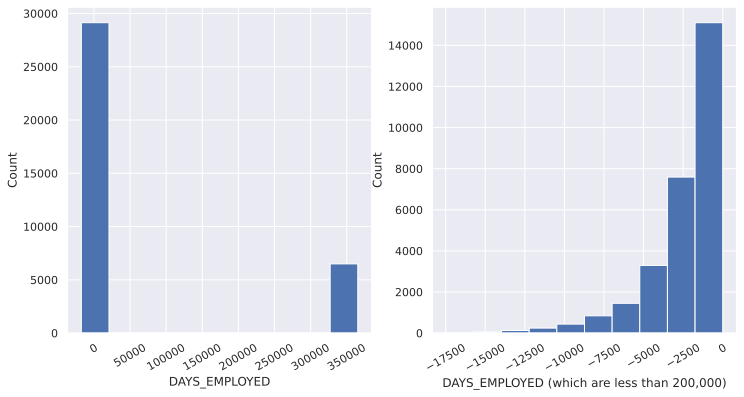

In [138]:
# Affiche l'histogramme du nombre de jours employés
fig = plt.figure(1, figsize=(12, 6))
plt.subplot(1, 2, 1)
app['DAYS_EMPLOYED'].hist()
plt.xlabel('DAYS_EMPLOYED')
plt.ylabel('Count')
plt.xticks(rotation=30)

# Affiche l'histogramme pour les valeurs normales
plt.subplot(1, 2, 2)
app.loc[app['DAYS_EMPLOYED'] < 200000, 'DAYS_EMPLOYED'].hist()
plt.xlabel('DAYS_EMPLOYED (which are less than 200,000)')
plt.ylabel('Count')
plt.xticks(rotation=30)
plt.show()

In [139]:
# Affiche les valeurs abérrantes
values_to_nan = app.loc[app['DAYS_EMPLOYED'] > 366, 'DAYS_EMPLOYED'].unique()
print(values_to_nan)

[365243]


In [140]:
# Remplace la valeur abérrante par NaN
app['DAYS_EMPLOYED'].replace(values_to_nan, np.nan, inplace=True)

In [141]:
# Sauvegarde des résultats
app.to_csv("/content/drive/MyDrive/P7_credit/output/app_no_encoded_no_featureengineering.csv")

### 2.3 Feature Engineering <a class="anchor" id="Section_2_3"></a>

#### 2.3.1 'Feature Engineering' automatisé <a class="anchor" id="sSection_2_3_1"></a>

In [142]:
# Create an entity set
es = ft.EntitySet(id='applications')

In [143]:
# Add dataframe to entityset
es = es.add_dataframe(dataframe_name='applications',
                              dataframe=app,
                              index='SK_ID_CURR')



In [144]:
# Affiche le type de chaque colonne
es['applications'].dtypes

SK_ID_CURR                       int64
TARGET                         float64
NAME_CONTRACT_TYPE            category
CODE_GENDER                   category
FLAG_OWN_CAR                  category
                                ...   
AMT_REQ_CREDIT_BUREAU_WEEK     float64
AMT_REQ_CREDIT_BUREAU_MON      float64
AMT_REQ_CREDIT_BUREAU_QRT      float64
AMT_REQ_CREDIT_BUREAU_YEAR     float64
Test                              bool
Length: 123, dtype: object

Certaines variables sont de type 'numeric' alors qu'elles devraient être de type 'boolean'.

Les types sont changés manuellement via le package FeatureTools

In [145]:
from featuretools import *

In [146]:
from woodwork.logical_types import Boolean 

In [147]:
import woodwork
import featuretools
# Featuretools datatypes
BOOL = woodwork.logical_types.Boolean

# Manually define datatypes in app dataframe
variable_types = {
    'FLAG_MOBIL': BOOL,
    'FLAG_EMP_PHONE': BOOL,
    'FLAG_WORK_PHONE': BOOL,
    'FLAG_CONT_MOBILE': BOOL,
    'FLAG_PHONE': BOOL,
    'FLAG_EMAIL': BOOL,
    'REG_REGION_NOT_LIVE_REGION': BOOL,
    'REG_REGION_NOT_WORK_REGION': BOOL,
    'LIVE_REGION_NOT_WORK_REGION': BOOL,
    'REG_CITY_NOT_LIVE_CITY': BOOL,
    'REG_CITY_NOT_WORK_CITY': BOOL,
    'LIVE_CITY_NOT_WORK_CITY': BOOL,
    'FLAG_DOCUMENT_2': BOOL,
    'FLAG_DOCUMENT_3': BOOL,
    'FLAG_DOCUMENT_4': BOOL,
    'FLAG_DOCUMENT_5': BOOL,
    'FLAG_DOCUMENT_6': BOOL,
    'FLAG_DOCUMENT_7': BOOL,
    'FLAG_DOCUMENT_8': BOOL,
    'FLAG_DOCUMENT_9': BOOL,
    'FLAG_DOCUMENT_10': BOOL,
    'FLAG_DOCUMENT_11': BOOL,
    'FLAG_DOCUMENT_12': BOOL,
    'FLAG_DOCUMENT_13': BOOL,
    'FLAG_DOCUMENT_14': BOOL,
    'FLAG_DOCUMENT_15': BOOL,
    'FLAG_DOCUMENT_16': BOOL,
    'FLAG_DOCUMENT_17': BOOL,
    'FLAG_DOCUMENT_18': BOOL,
    'FLAG_DOCUMENT_19': BOOL,
    'FLAG_DOCUMENT_20': BOOL,
    'FLAG_DOCUMENT_21': BOOL,
}

# Add dataframe to entityset, using manual datatypes

es = es.add_dataframe(dataframe_name='applications',
                              dataframe=app,
                              index='SK_ID_CURR', logical_types=variable_types)

/usr/local/lib/python3.7/dist-packages/featuretools/entityset/entityset.py:660: UserWarning:

A Woodwork-initialized DataFrame was provided, so the following parameters were ignored: index, logical_types



In [148]:
# Affiche le type de chaque colonne
es['applications'].ww

,Physical Type,Logical Type,Semantic Tag(s)
Column,,,
SK_ID_CURR,int64,Integer,['index']
TARGET,float64,Double,['numeric']
NAME_CONTRACT_TYPE,category,Categorical,['category']
CODE_GENDER,category,Categorical,['category']
FLAG_OWN_CAR,category,Categorical,['category']
FLAG_OWN_REALTY,category,Categorical,['category']
CNT_CHILDREN,int64,Integer,['numeric']
AMT_INCOME_TOTAL,float64,Double,['numeric']
AMT_CREDIT,float64,Double,['numeric']


Le changement de types s'est effectué correctement

In [149]:
woodwork.list_semantic_tags

<function woodwork.type_sys.utils.list_semantic_tags>

In [150]:
# Featuretools datatypes
BOOL = woodwork.logical_types.Boolean
#ID = woodwork.logical_types.

# Add bureau dataframe to entityset
es = es.add_dataframe(
    dataframe_name='bureau',
    dataframe=bureau,
    index='SK_ID_BUREAU',
    )

# Add bureau_balance dataframe to entityset
es = es.add_dataframe(
    dataframe_name='bureau_balance',
    dataframe=bureau_balance,
    index='New',
    )

# Add cash_balance dataframe to entityset
es = es.add_dataframe(
    dataframe_name='cash_balance',
    dataframe=cash_balance,
    index='New',
    )

# Add card_balance dataframe to entityset
es = es.add_dataframe(
    dataframe_name='card_balance',
    dataframe=card_balance,
    index='New',
    )

# Add prev_app dataframe to entityset
es = es.add_dataframe(
    dataframe_name='prev_app',
    dataframe=prev_app,
    index='SK_ID_PREV',
    )

# Add payments dataframe to entityset
es = es.add_dataframe(
    dataframe_name='payments',
    dataframe=payments,
    index='New',
    )

/usr/local/lib/python3.7/dist-packages/featuretools/entityset/entityset.py:1568: UserWarning:

index New not found in dataframe, creating new integer column



In [151]:
# Define relationships between dataframes
relationships = [
  # parent_entity   parent_variable  child_entity      child_variable
  ('applications', 'SK_ID_CURR',    'bureau',         'SK_ID_CURR'),
  ('bureau',       'SK_ID_BUREAU',  'bureau_balance', 'SK_ID_BUREAU'),
  ('applications', 'SK_ID_CURR',    'prev_app',       'SK_ID_CURR'),
  ('applications', 'SK_ID_CURR',    'cash_balance',   'SK_ID_CURR'),
  ('applications', 'SK_ID_CURR',    'payments',       'SK_ID_CURR'),
  ('applications', 'SK_ID_CURR',    'card_balance',   'SK_ID_CURR')
]

# Create the relationships
for pe, pv, ce, cv in relationships:
    #es = es.add_relationship(ft.Relationship(es[pe][pv], es[ce][cv]))
    relationship = ft.Relationship(entityset=es , parent_dataframe_name= pe, parent_column_name= pv, child_dataframe_name= ce, child_column_name= cv)
    es =es.add_relationship(relationship = relationship)
    
    

In [152]:
es

Entityset: applications
  DataFrames:
    applications [Rows: 35625, Columns: 123]
    bureau [Rows: 171642, Columns: 17]
    bureau_balance [Rows: 2729992, Columns: 4]
    cash_balance [Rows: 1000135, Columns: 9]
    card_balance [Rows: 384031, Columns: 24]
    prev_app [Rows: 167021, Columns: 37]
    payments [Rows: 1360540, Columns: 9]
  Relationships:
    bureau.SK_ID_CURR -> applications.SK_ID_CURR
    bureau_balance.SK_ID_BUREAU -> bureau.SK_ID_BUREAU
    prev_app.SK_ID_CURR -> applications.SK_ID_CURR
    cash_balance.SK_ID_CURR -> applications.SK_ID_CURR
    payments.SK_ID_CURR -> applications.SK_ID_CURR
    card_balance.SK_ID_CURR -> applications.SK_ID_CURR

In [153]:
# Define which primitives to use
agg_primitives =  ['count', 'median'] #, 'min', 'max']
trans_primitives = ['cum_sum']

In [154]:
# Run deep feature synthesis
app, features = ft.dfs(entityset= es, 
                       target_dataframe_name ='applications',
                       trans_primitives=trans_primitives,
                       agg_primitives=agg_primitives, 
                       max_depth=2)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4486: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



In [155]:
# Liste de toutes les variables
app.columns.tolist()

['TARGET',
 'NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'OCCUPATION_TYPE',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'WEEKDAY_APPR_PROCESS_START',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'ORGANIZATION_TYPE',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'YEARS_BU

In [156]:
# Remove low information features
app = selection.remove_low_information_features(app)
print("Le nombre de colonnes est de {}".format(len(app.columns)))

Le nombre de colonnes est de 448


#### 2.3.2 Feature Engineering manuel <a class="anchor" id="sSection_2_3_2"></a>

Cette étape de 'Feature Engineering' permet de créer de nouvelles features pertinentes issues de celles existantes pour aider le modèle :
   
   - Le ratio temps travaillé/âge
   
   - Le ratio crédit/revenu
   
   - le ratio revenu/annuité
   
   - le ratio revenu/annuité/âge
   
   - le ratio crédit/annuité
   
   - le ratio crédit/annuité/âge
    


In [157]:
def manual_feature_engineering(app) :
    
    #Certaines compositions pertinentes de variables permettent d'aider le modèle
    
    app['PROPORTION_LIFE_EMPLOYED'] = app['DAYS_EMPLOYED'] / app['DAYS_BIRTH']
    app['INCOME_TO_CREDIT_RATIO'] = app['AMT_INCOME_TOTAL'] / app['AMT_CREDIT'] 
    app['INCOME_TO_ANNUITY_RATIO'] = app['AMT_INCOME_TOTAL'] / app['AMT_ANNUITY']
    app['INCOME_TO_ANNUITY_RATIO_BY_AGE'] = app['INCOME_TO_ANNUITY_RATIO'] * app['DAYS_BIRTH']
    app['CREDIT_TO_ANNUITY_RATIO'] = app['AMT_CREDIT'] / app['AMT_ANNUITY']
    app['CREDIT_TO_ANNUITY_RATIO_BY_AGE'] = app['CREDIT_TO_ANNUITY_RATIO'] * app['DAYS_BIRTH']
    app['INCOME_TO_FAMILYSIZE_RATIO'] = app['AMT_INCOME_TOTAL'] / app['CNT_FAM_MEMBERS']
    
    return app

In [158]:
# Feature engineering manuel
app = manual_feature_engineering(app)

In [159]:
# Sauvegarde des résultats
app.to_csv("/content/drive/MyDrive/P7_credit/output/app_no_enconded_featureengineering.csv")

### 2.4 Données manquantes <a class="anchor" id="Section_2_4"></a>

#### Proportions des données manquantes

In [160]:
def missing_values(df, display=False, printf=True, top_n_missing=30, title=""): 
    
    # Calcul de la proportion de données manquantes pour chaque colonne

    null_prop = df.isnull().sum(axis=0).sum()/len(df)/len(df.columns)*100
    null = df.isnull().sum(axis=0).sort_values()/len(df)*100
    
    if printf:
        print("Le pourcentage moyen de valeurs manquantes est de {:.2f}%".format(null_prop))
    
    # Si display=True, plot :
    if display :
        fig = plt.figure(figsize=(14, 6))
        plt.axhline(y=null_prop, color='k', linestyle='--', lw=2)
        plt.legend(['{:.2f}% global de données manquantes'.format(null_prop)], fontsize=13)

        data_to_plot = pd.DataFrame(null).sort_values(by = 0, ascending=False)[0: top_n_missing]
        
        sns.barplot(data_to_plot.index, data_to_plot[0])
        plt.ylabel("%")
        plt.title(title)
        labels = ['\n'.join(wrap(l, top_n_missing)) for l in data_to_plot.index]        
        plt.xticks(range(len(labels)), labels, rotation='vertical')
        
        plt.show()
    else :
        return null

In [161]:
# On récupère les données d'entrainement
train_set = app[app['Test'] == False]
# On r"cupère les données test
test_set = app[app['Test'] == True]

In [162]:
missing_values(train_set,
               display=False,
               title="Pourcentage de valeurs manquantes pour le jeu d'entrainement")

Le pourcentage moyen de valeurs manquantes est de 30.51%


TARGET                                                 0.000000
COUNT(cash_balance)                                    0.000000
COUNT(payments)                                        0.000000
COUNT(card_balance)                                    0.000000
CUM_SUM(AMT_ANNUITY)                                   0.000000
                                                        ...    
CUM_SUM(MEDIAN(prev_app.RATE_INTEREST_PRIMARY))       98.439075
MEDIAN(prev_app.CUM_SUM(RATE_INTEREST_PRIVILEGED))    98.439075
MEDIAN(prev_app.RATE_INTEREST_PRIVILEGED)             98.439075
CUM_SUM(MEDIAN(prev_app.RATE_INTEREST_PRIVILEGED))    98.439075
MEDIAN(prev_app.CUM_SUM(RATE_INTEREST_PRIMARY))       98.439075
Length: 455, dtype: float64

In [163]:
missing_values(test_set,
               display=False,
               title="Pourcentage de valeurs manquantes pour le jeu test")

Le pourcentage moyen de valeurs manquantes est de 28.69%


INCOME_TO_FAMILYSIZE_RATIO                              0.000000
COUNT(card_balance)                                     0.000000
CUM_SUM(COUNT(bureau))                                  0.000000
CUM_SUM(AMT_CREDIT)                                     0.000000
CUM_SUM(AMT_GOODS_PRICE)                                0.000000
                                                         ...    
MEDIAN(prev_app.RATE_INTEREST_PRIMARY)                 97.496922
MEDIAN(prev_app.CUM_SUM(RATE_INTEREST_PRIVILEGED))     97.496922
CUM_SUM(MEDIAN(prev_app.RATE_INTEREST_PRIVILEGED))     97.496922
CUM_SUM(TARGET)                                       100.000000
TARGET                                                100.000000
Length: 455, dtype: float64

#### Suppression des valeurs manquantes

Les colonnes dont les valeurs manquantes sont supérieurs à 90 % sont supprimés des données

In [164]:
def drop_missing_values(app):

    # On récupère les données d'entrainement
    train_set = app[app['Test'] == False]
    # On r"cupère les données test
    test_set = app[app['Test'] == False]
    
    # Détermine la proportion de valeurs manquantes pour les données d'entrainement
    missing_train = missing_values(train_set, printf=False)
    # Détermine la proportion de valeurs manquantes pour les données test
    missing_test = missing_values(test_set, printf=False)
    
    # Défini la liste des variables dont les valeurs manquantes sont supérieurs à 10%
    # Jeu d'entrainement
    var_missing_values_train = list(missing_train[missing_train > 90].index)
    # Jeu test
    var_missing_values_test = list(missing_test[missing_test > 90].index)
    # Concaténation des variables + suppression des doublons
    var_missing_values = list(set(var_missing_values_train + var_missing_values_test))
    
    # Suppression des colomnes dont les valeurs sont manquantes
    app.drop(columns=var_missing_values, inplace=True)
    
    # Affiche le nouveau pourcentage de valeurs manquantes
    null_prop = app.isnull().sum(axis=0).sum()/len(app)/len(app.columns)*100

    print('Le nouveau pourcentage de valeurs manquantes est de {:.2f}%'.format(null_prop))
    return app

In [165]:
app = drop_missing_values(app)

Le nouveau pourcentage de valeurs manquantes est de 27.08%


## 3. Encodage des variables catégorielles <a class="anchor" id="partie3"></a>

Les variables catégorielles doivent être encodés pour être utilisables par les modèles. Les variables cycliques comme les jours de la semaine sont encodées en deux dimensions, les variables contenant uniquement 2 classes sont assignées à des 0 ou et des 1. Pour les variables à plus de 2 classes, un one-hot encoding est appliqué.

### 3.1 Encondage des 'variables temporelles' <a class="anchor" id="Section_3_1"></a>

La colomne 'WEEKDAY_APPR_PROCESS_START' contient des informations catégorielles concernant le jour de la semaine. Une manière communément utilisée en ML est d'encoder la variable en deux dimensions en utilisant un système de coordonnées polaires. Les jours de la semaine sont alors représentés sur un cercle et le nombre de dimensions est réduit par rapport à un one-hot-encoding.

In [166]:
def polar_projection(app, col):

    # Create map from categories to polar projection
    DOW_map = {
        'MONDAY':    0,
        'TUESDAY':   1,
        'WEDNESDAY': 2,
        'THURSDAY':  3,
        'FRIDAY':    4,
        'SATURDAY':  5,
        'SUNDAY':    6,
    }
    DOW_map1 = {k: np.cos(2*np.pi*v/7.0) for k, v in DOW_map.items()}
    DOW_map2 = {k: np.sin(2*np.pi*v/7.0) for k, v in DOW_map.items()}

    # Show encoding of days of week -> circle
    days = ['MONDAY', 'TUESDAY', 'WEDNESDAY', 'THURSDAY', 'FRIDAY', 'SATURDAY', 'SUNDAY']
    tt = np.linspace(0, 2*np.pi, 200)
    xx = np.cos(tt)
    yy = np.sin(tt)
    plt.plot(xx, yy)
    plt.gca().axis('equal')
    plt.xlabel('Encoded Dimension 1')
    plt.ylabel('Encoded Dimension 2')
    plt.title('2D Projection of days of the week')
    for day in days:
        plt.text(DOW_map1[day], DOW_map2[day], day, ha='center')
    plt.show()
    
    # WEEKDAY_APPR_PROCESS_START to polar coords
    app[col + '_1'] = app[col].map(DOW_map1)
    app[col + '_2'] = app[col].map(DOW_map2)
    app.drop(columns=col, inplace=True)
    
    return app

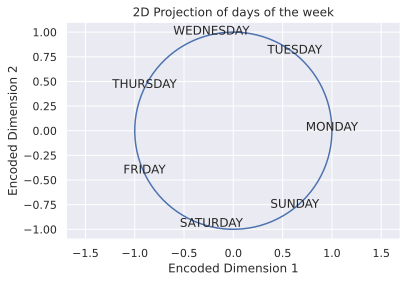

In [167]:
app = polar_projection(app, col='WEEKDAY_APPR_PROCESS_START')

Cet encodage conserve le caractère cyclique des jours de la semaine, tout en limitant le nombre de dimensions.

### 3.2 Encodage des autres variables catégorielles <a class="anchor" id="Section_3_2"></a>

For the housing-related features (e.g. LIVINGAPARTMENTS_MODE, BASEMENTAREA_AVG, etc) there are combinations of some PREFIX (e.g. LIVINGAPARTMENTS, BASEMENTAREA, etc) and some POSTFIX (e.g. MODE, MEDI, AVG, etc) into a variable PREFIX_POSTFIX. However, if one value for a given PREFIX is empty, the other values for that PREFIX will also be empty.

For each column which has some empty values, we want to add an indicator column which is 1 if the value in the corresponding column is empty, and 0 otherwise. However, if we do this with the housing-related features, we'll end up with a bunch of duplicate columns! This is because the same samples have null values across all the POSTFIX columns for a given PREFIX. The same problem crops up with the CREDIT_BUREAU-related features. To handle this problem, after creating the null indicator columns, we'll check for duplicate columns and merge them.

So, first we'll add columns to indicate where there are empty values in each other column.

Then we can label encode categorical features with only 2 possible values (that is, turn the labels into either 0 or 1).

Then we'll one-hot encode the categorical features which have more than 2 possible values.

In [172]:
test = app.copy()

In [86]:
from pandas.core.arrays.categorical import Categorical
from dask.dataframe.dispatch import categorical_dtype
def cat_encoder(app):
    
    """
    Encode les variables catégorielles avec un label encoder ou un one hot encoding suivant
    le nombre de valeurs différentes prises par chaque variable    
    """

    # Label encoder
    label_encoder = LabelEncoder()
    
    # categorials features to one hot encode
    cat_features = []
    col_to_del = []
    
    for col in app: 
        print(col)
        if col != 'Test' and col != 'TARGET':
            if app[col].dtype == Categorical : 
                # Label encode binary fearures in training set
                if app[col].nunique() == 2:
                    app[col] = label_encoder.fit_transform(app[col])
                # get colunms to one hot encode
                elif app[col].nunique() > 2:
                    cat_features.append(col)

    # One-hot encode categorical features in train set
    app = pd.get_dummies(app, columns=cat_features)
       
    return app

In [87]:
def cat_encoder(app):
    
    """
    Encode les variables catégorielles avec un label encoder ou un one hot encoding suivant
    le nombre de valeurs différentes prises par chaque variable    
    """

    # Label encoder
    label_encoder = LabelEncoder()
    
    # categorials features to one hot encode
    cat_features = []
    col_to_del = []
    
    for col in app: 
        if col != 'Test' and col != 'TARGET':
            # Add indicator columns for empty values
            app_null = app[col].isnull()
            if app_null.sum() > 0:
                app[col + '_ISNULL'] = app_null
                col_to_del.append(col + '_ISNULL')

            if app[col].dtype == Categorical: 
                # Label encode binary fearures in training set
                if app[col].nunique() == 2:
                    if col + '_ISNULL' in app.columns:  # missing values here?
                        app.loc[app[col + '_ISNULL'], col] = 'NaN'
                    app[col] = label_encoder.fit_transform(app[col])
                    if col + '_ISNULL' in app.columns:  # re-remove missing vals
                        app.loc[app[col + '_ISNULL'], col] = np.nan
                # get colunms to one hot encode
                elif app[col].nunique() > 2:
                    cat_features.append(col)

    # One-hot encode categorical features in train set
    app = pd.get_dummies(app, columns=cat_features)
    
    # Suppresion des colonnes nulles          
    app.drop(columns=col_to_del, inplace=True)
    
    return app

In [169]:
# ##########################################################
# Fonction pour codage des varaibles categorielles
# ##########################################################
def get_dummies_encoder(df, nan_as_category=True):
    original_columns = list(df.columns)
    categorical_columns = df.select_dtypes(["category",
                                            "object"]).columns.tolist()
    df = pd.get_dummies(df, columns=categorical_columns, prefix_sep='_',
                        dummy_na=nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    #return df, new_columns
    return df 
# ##########################################################

In [179]:
# Encondage des variables catégorielles
app = get_dummies_encoder(test)

In [182]:
app.head(2)

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,...,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA,ORGANIZATION_TYPE_nan,FONDKAPREMONT_MODE_not specified,FONDKAPREMONT_MODE_org spec account,FONDKAPREMONT_MODE_reg oper account,FONDKAPREMONT_MODE_reg oper spec account,FONDKAPREMONT_MODE_nan,HOUSETYPE_MODE_block of flats,HOUSETYPE_MODE_specific housing,HOUSETYPE_MODE_terraced house,HOUSETYPE_MODE_nan,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,WALLSMATERIAL_MODE_nan,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,EMERGENCYSTATE_MODE_nan,WEEKDAY_APPR_PROCESS_START_1_-0.9009688679024191,WEEKDAY_APPR_PROCESS_START_1_1.0,WEEKDAY_APPR_PROCESS_START_1_-0.2225209339563146,WEEKDAY_APPR_PROCESS_START_1_0.6234898018587334,WEEKDAY_APPR_PROCESS_START_1_-0.900968867902419,WEEKDAY_APPR_PROCESS_START_1_0.6234898018587336,WEEKDAY_APPR_PROCESS_START_1_-0.22252093395631434,WEEKDAY_APPR_PROCESS_START_1_nan,WEEKDAY_APPR_PROCESS_START_2_-0.433883739117558,WEEKDAY_APPR_PROCESS_START_2_0.0,WEEKDAY_APPR_PROCESS_START_2_-0.9749279121818236,WEEKDAY_APPR_PROCESS_START_2_-0.7818314824680299,WEEKDAY_APPR_PROCESS_START_2_0.43388373911755823,WEEKDAY_APPR_PROCESS_START_2_0.7818314824680298,WEEKDAY_APPR_PROCESS_START_2_0.9749279121818236,WEEKDAY_APPR_PROCESS_START_2_nan
0,100002,1.0,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637.0,-3648.0,-2120,NaN,1,1,0,1,1,0,1.0,2,2,10,0,0,0,0,0,0,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,...,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
1,100003,0.0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188.0,-1186.0,-291,NaN,1,1,0,1,1,0,2.0,1,1,11,0,0,0,0,0,0,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,...,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0


#### Sauvegarde des données pré-traités en fichier csv

In [181]:
app.reset_index(level=0, inplace=True)

In [183]:
# Sauvegarde des données
app.to_csv("/content/drive/MyDrive/P7_credit/output/app_encoded.csv")